# Compressed sensing project:
## Author: Antoine Habis
### Implementation of the stochastic optimization algorithms 
## Paper source:  **$\underline{Unsupervised~Alignment~of~Embeddings~with~Wasserstein~Procrustes}$**
## Dataset used: Faust DATASET $\&$ created datas

# Requirements:

In [1]:
!pip install plyfile
!pip install PlyData
!pip install numpy cython
!pip install POT
!pip install git+https://github.com/nipy/mindboggle
!pip install vtk
from mindboggle.shapes.laplace_beltrami import spectrum_per_label

  Created wheel for POT: filename=POT-0.6.0-cp37-cp37m-win_amd64.whl size=150034 sha256=819988c74b76bb35f9e211df841a1e66a270decd0cafbff6007d3c469e792e65
  Stored in directory: c:\users\antoine\appdata\local\pip\cache\wheels\ee\2f\1b\ae58b00f35bc7fceed4899ac6b569bf50d2d5b4a1adccbad51
Successfully built POT
  Cloning https://github.com/nipy/mindboggle to d:\temp\pip-req-build-5a2j4x4i
  Created wheel for Mindboggle: filename=Mindboggle-1.3.8-py3-none-any.whl size=569219 sha256=280891451586be2eb7b774fc36395e2a834ab07d53d6ab2a8d548f8f47c52392
  Stored in directory: D:\TEMP\pip-ephem-wheel-cache-osz4du_z\wheels\e4\3b\aa\feb7c45be87d6a868a9899142c6f0e76ed9672a1023956b7ef
Successfully built Mindboggle


  Running command git clone -q https://github.com/nipy/mindboggle 'D:\TEMP\pip-req-build-5a2j4x4i'


Could not check for version updates:  No module named 'etelemetry'
Running mindboggle version 1.3.8 (latest: Unknown)


In [4]:
from mindboggle.shapes.laplace_beltrami import spectrum_per_label
import glob, os
from plyfile import PlyData, PlyElement
import numpy as np
from ot import sinkhorn
from numpy.linalg import svd
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from vtk.util.numpy_support import numpy_to_vtk

# Import datas

In [7]:
path_X = 'MPI-FAUST/test/scans/test_scan_000.ply'
path_Y = 'MPI-FAUST/test/scans/test_scan_003.ply'

In [8]:
X_ply = PlyData.read(path_X)
Y_ply = PlyData.read(path_Y)

# Transform ply object into numpy arrays

In [9]:
X_tuple = np.array(X_ply.elements[0][:])
X = np.vstack((X_tuple['x'], X_tuple['y'].T, X_tuple['z'].T))
X = X.T

Y_tuple = np.array(Y_ply.elements[0][:])
Y = np.vstack((Y_tuple['x'], Y_tuple['y'].T, Y_tuple['z'].T))
Y = Y.T

# 3d representation of the datas

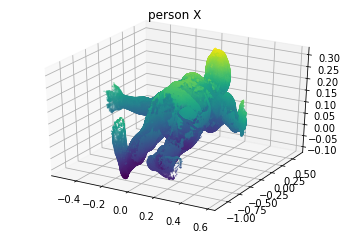

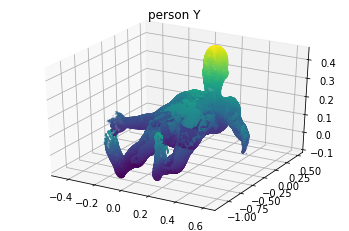

In [10]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('person X')
ax.scatter3D(X_tuple['x'], X_tuple['y'], X_tuple['z'], c=X_tuple['z'],s = 0.2)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('person Y')
ax.scatter3D(Y_tuple['x'], Y_tuple['y'], Y_tuple['z'], c=Y_tuple['z'],s = 0.2)


#Learn the orthogonal matrix in order to map X to Y

#First: set same dimensions for X and Y:

In [11]:
nx = X.shape[0]
ny = Y.shape[0]
print('numer of points of X: nx = {}\nnumber of points of Y: ny = {}'.format(nx, ny))

numer of points of X: nx = 177638
number of points of Y: ny = 175992


X and Y don't have the same number of points.
X has more points than Y.

Let's make them have equal dimension by erasing random points of X with equal chances.

In [12]:
##### Here we make X have same dimension than Y
keep_points = np.random.choice(nx, size = ny, replace = False)
X = X[keep_points]
nx = X.shape[0]
print('numer of points of X: nx = {}\nnumber of points of Y: ny = {}'.format(nx, ny))

numer of points of X: nx = 175992
number of points of Y: ny = 175992


In [13]:
print(X.shape)

(175992, 3)


We have now datas with equal length.

# Here we implement the *Algorithm 1*: from the paper 
##**"Unsupervised Alignment of Embeddings with Wassertein Procrustes"**



In [14]:
def find_orthogonal(X, Y, R, lr=10., batch_size=200, nepochs=8, niter=100, verbose=True):

  n = X.shape[0]

  for epoch in range(1, nepochs + 1):

      for i in range(1, niter + 1):

          # creation of the minibatch randomly
          xt = X[np.random.permutation(n)[:batch_size], :]
          yt = Y[np.random.permutation(n)[:batch_size], :]
          # compute the optimal permutation 
          C = -np.dot(np.dot(xt, R), yt.T)
          P = sinkhorn(np.ones(batch_size), np.ones(batch_size), C, 0.05, stopThr=1e-3)
          # compute the gradient
          G = - np.dot(xt.T, np.dot(P, yt))
          R -= lr / batch_size * G
          # project on the orthogonal space
          U, s, VT = svd(R)
          R = np.dot(U, VT)

      batch_size *= 2
      niter //= 4
  return R

**Idea of the Algorithm:**




We want to minimize the objective function $W_2^2(XQ,Y)$ over $Q$.

More especially we want to find $\underset{Q \in \mathcal{0}_d}{argmin} \qquad \underset{P \in \mathcal{P}_n}{min}||XQ -PY||_2^2$.

The problem is: the dimension of $P$ is $n^2$ which is way too much so the value of the minimum is really hard to compute.

That is why we want to use a mini batch gradient descent.

The idea is to take a sample of size $b$ of $X$ and $Y$ with $b<<n$
Now the optimal value of P is easier to compute.

Now that we found an optimal value for P we want to get closer to the optimal value of Q.

To do this, we compute a gradient descent with respect to the loss as if Q was a ordinary matrix and then we compute it's  projection onto the space of orthogonal matrices.

And we repeat this patern 



### The problem in this algorithm is that the result depends a lot on the initialization of the algorithm $Q_{0}$. To have a good initialization, The paper propose to find the minimum of the convex relaxation $Q^*$ of the problem and then apply this algorithm with Q^* with initial value. 

### We couldn't apply the relaxation minimization algorithm because of issues with the virtual memory which was too small.


## Let's try to implement the algorithm on a toy dataset with a really easy figure to see if it's working well.

### For the Toy dataset, we use a representation in 2 dimensions of the letter H and a rotation of 45 degrees of this letter for the target data.

##A rotation of 45 degree is a really easy transformation so we expect the predicted value $Y_{predict}$ to be the same as the true value of Y.

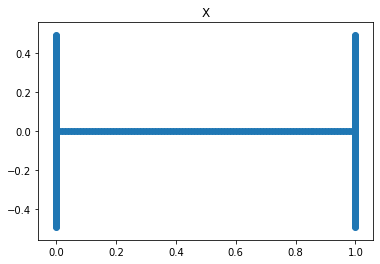

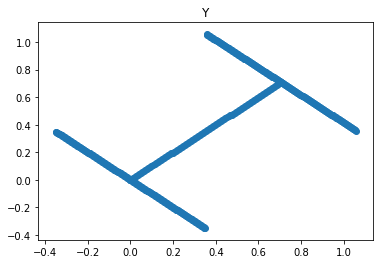

In [15]:
#######coordinate of the letter H in 2 dimension#######
x1 = np.zeros(200) 
x2 = np.arange(100)
x = np.concatenate((x1,x2,100 + x1))/100

y1 = np.arange(100)
y2 = -y1
y3 = np.zeros(100)
y = np.concatenate((y1,y2,y3,y1,y2))/200
#######The associated data#######
X_h = np.vstack((x,y))
#######The rotation matrix to build the target points#####
theta = np.pi/4
cos = np.cos(theta)
sin = np.sin(theta)
rot = np.array([[cos, -sin], [sin, cos]])
#######The target data#######
Y_h = np.dot(rot, X_h)
#######Representation of the two figures in 2d#######
plt.scatter(X_h[0], X_h[1])
plt.title('X')
plt.show()

plt.scatter(Y_h[0], Y_h[1])
plt.title('Y')
plt.show()

In [16]:
X_h = X_h.T
Y_h = Y_h.T

In [17]:
######We apply the algorithm on the data to compute the orthogonal matrix######
R_h = find_orthogonal(X_h, Y_h, R = np.ones((2,2)), lr=10., batch_size=10, nepochs=10, niter=100, verbose=True)

In [18]:
Y_h_predict = np.dot(X_h,R_h)

Text(0.5, 1.0, 'Y_predict')

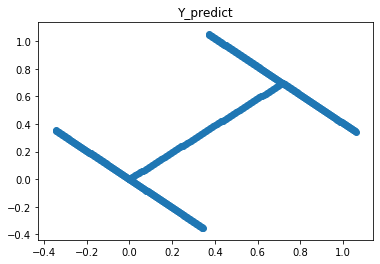

In [19]:
plt.scatter(Y_h_predict[:,0], Y_h_predict[:,1])
plt.title('Y_predict')

The algorithm works really well on the toy dataset, the predicted figure $Y_{predict}$ is the same as the real initial figure $Y$


# Now let's try on more complex datas: humans and more complex transformations

In [20]:
R = find_orthogonal(X, Y , R = np.ones((3,3)), lr=10., batch_size=200, nepochs=8, niter=1000, verbose=True)

In [21]:
Y_predict = np.dot(X,R)
Y_predict.shape

(175992, 3)

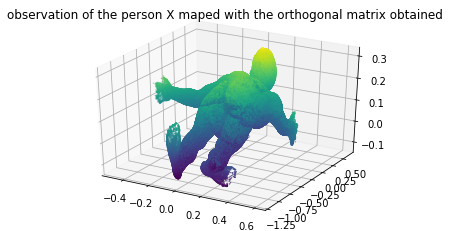

In [22]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('observation of the person X maped with the orthogonal matrix obtained')
ax.scatter3D(Y_predict[:,0], Y_predict[:,1], Y_predict[:,2], c=Y_predict[:,2],s = 0.2)

Here we can't quite see the difference between the original data X and the data obtained by maping with the orthogonal matrix obtained.

This is due to the fact that the two persons: X and Y are facing the same direction.

Let's try with a different pair of images with different facing directions.

In [23]:
###This function loads the data and preprocess it automatically
def obtain_datas (path_X, path_Y):

  """input: path of a ply file for X 
            path of a ply file for X
            
      return: numpy array of X and Y"""
      
  X_ply = PlyData.read(path_X)
  Y_ply = PlyData.read(path_Y)

  X_tuple = np.array(X_ply.elements[0][:])
  X = np.vstack((X_tuple['x'], X_tuple['y'].T, X_tuple['z'].T))
  X = X.T

  Y_tuple = np.array(Y_ply.elements[0][:])
  Y = np.vstack((Y_tuple['x'], Y_tuple['y'].T, Y_tuple['z'].T))
  Y = Y.T

  nx = X.shape[0]
  ny = Y.shape[0]

  if nx>ny:
    keep_points = np.random.choice(nx, size = ny, replace = False)
    X = X[keep_points]
  else : 
    keep_points = np.random.choice(ny, size = nx, replace = False)
    Y = Y[keep_points]
  return X, Y

## Dataset with people not facing the same direction

In [24]:
path_X1 = 'MPI-FAUST/test/scans/test_scan_013.ply'
path_Y1 = 'MPI-FAUST/test/scans/test_scan_008.ply'
X_1, Y_1 = obtain_datas(path_X1, path_Y1)

print(X_1.shape, Y_1.shape)

(166492, 3) (166492, 3)


# Representation of the datas in 3D

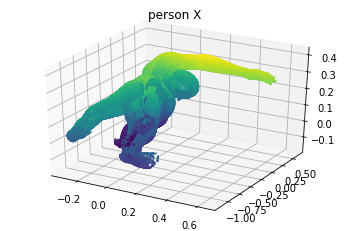

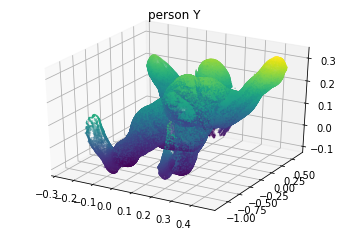

In [25]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('person X')
ax.scatter3D(X_1[:,0], X_1[:,1], X_1[:,2], c=X_1[:,2],s = 0.2)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('person Y')
ax.scatter3D(Y_1[:,0], Y_1[:,1], Y_1[:,2], c=Y_1[:,2],s = 0.2)

In [26]:
R = find_orthogonal(X_1, Y_1 , R = np.ones((3,3)), lr=10., batch_size=200, nepochs=8, niter=1000, verbose=True)

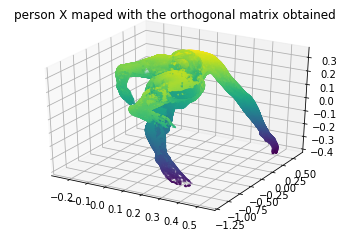

In [27]:
Y_map = np.dot(X_1,R)
Y_map.shape
Y_map[:,0].shape
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('person X maped with the orthogonal matrix obtained')
ax.scatter3D(Y_map[:,0], Y_map[:,1], Y_map[:,2], c=Y_map[:,2],s = 0.2)

### We can see that the person was rotated along the good axis, however the rotation is not good and furthermore, we want more than just rotating the initial figure. We want to get the exact Y.

### We can't do the transformation between X and Y if we only have the 3 dimensionnal coordinates as features. 

### We need more information!


##### To add features, we used the spectrum of the laplacian Beltrami operator but we didn't manage to make it work because of issues with vtk files.

#### We though it could be nice to apply the algorithm with 3d Datas so we did the same thing we did before with the letter H but this time in 3 dimensions.

(50000,) (50000,) (50000,)


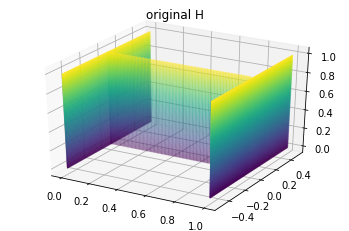

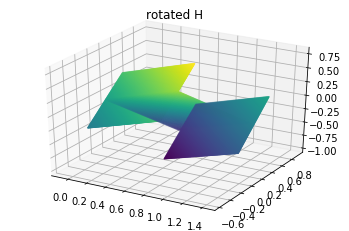

In [28]:
#######coordinate of the letter H in 3 dimension#######
w = 100
h = 200
d = 100
###build X coordinate###
x1 = np.zeros(d*h)
x2 = np.zeros(d)
for i in range(w-1):
  x2 = np.concatenate((x2,np.zeros(d) + i))
x3 = np.ones(d*h)*w

x = np.concatenate((x1,x2,x3))/w
###build Y coordinate###
y1 = - h//2 + np.zeros(d)
for i in range(h-1):
  yi = i - h//2 + np.zeros(d)
  y1 = np.concatenate((y1,yi))
y2 = np.zeros(w*d)
y3 = y1
y = np.concatenate((y1,y2,y3))/h

###build Z coordinate###
z = np.arange(d)
for i in range(h + h + w - 1):
  z = np.concatenate((z,np.arange(d)))
z = z/d
print(x.shape,y.shape,z.shape)

###Plot in 3D letter H##
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('original H')
ax.scatter3D(x, y, z, c=z,s = 0.2)

# #######The associated data#######
X_h_3d = np.vstack((x,y,z))

########Definition of the rotation matrix to build the target points#####

theta = np.pi/4
phi = np.pi/4
psi = np.pi/4

cos_theta, sin_theta = np.cos(theta), np.sin(theta)
cos_phi, sin_phi = np.cos(phi), np.sin(phi)
cos_psi, sin_psi = np.cos(psi), np.sin(psi)

rot_theta = np.array([[1,0,0],[0,cos_theta, -sin_theta], [0,sin_theta, cos_theta]])
rot_phi = np.array([[cos_phi,0,sin_phi],[0,1, 0], [-sin_phi,0, cos_phi]])
rot_psi = np.array([[cos_psi,-sin_psi,0],[sin_psi,cos_psi, 0], [0,0, 1]])

Rot = np.dot(rot_psi, np.dot(rot_phi,rot_theta))
#######creation of th target data#######
Y_h_3d = np.dot(Rot, X_h_3d)
#######Representation of the two figures in 2d#######

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('rotated H')
ax.scatter3D(Y_h_3d[0], Y_h_3d[1], Y_h_3d[2], c = Y_h_3d[2], s = 0.2)

In [29]:
X_h_3d = X_h_3d.T
Y_h_3d = Y_h_3d.T
print(X_h_3d.shape, Y_h_3d.shape)

(50000, 3) (50000, 3)


In [30]:
R_h_3d = find_orthogonal(X_h_3d, Y_h_3d, R = np.eye(3), lr=10., batch_size=50, nepochs=5, niter=100, verbose=True)

(50000, 3)


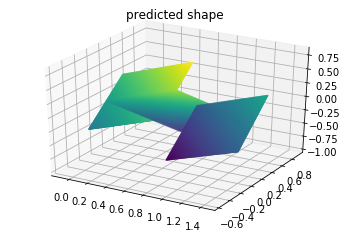

In [31]:
Y_predict = np.dot(X_h_3d,R_h_3d)
print(Y_predict.shape)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('predicted shape')
ax.scatter3D(Y_predict[:,0], Y_predict[:,1], Y_predict[:,2], c = Y_predict[:,2], s = 0.2)

Once again the predicted shape is the same than the true shape.
The algorithm works well.

Let's compare the true rotation matrix with the orthogonal matrix we found:

In [32]:
print('the value of the predicted orthogonal matrix is :\n \n {} \n \n'.format(R_h_3d))
print('the value of the orthogonal matrix we chose is \n \n {}'.format(Rot.T))

the value of the predicted orthogonal matrix is :
 
 [[ 0.52112851  0.49042232 -0.69850628]
 [-0.16961482  0.86160899  0.47839393]
 [ 0.83645436 -0.1308277   0.5321919 ]] 
 

the value of the orthogonal matrix we chose is 
 
 [[ 0.5         0.5        -0.70710678]
 [-0.14644661  0.85355339  0.5       ]
 [ 0.85355339 -0.14644661  0.5       ]]


We can see that the two orthogonal matrices are almost equal meaning that the algorithm found a good transformation